# Statistical inference on Histogram

In this tutorial, we will generate a mock histogram and see if our signal model is good enough to explain the experimental data.

In [1]:
import numpy as np
import spey
import matplotlib.pyplot as plt

Let us generate a histogram to be used in our example first. In below example, we generate three sets of data, signal ($n_s$), background ($n_b$) and observarions ($n$). The statistical uncertainties on the background yields are shown with black lines.

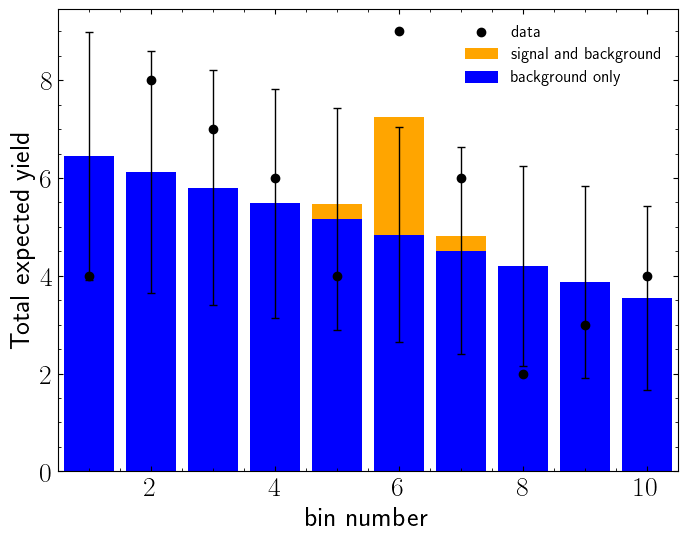

In [22]:
fig = plt.figure(figsize=(8, 6))
# Define the binning
nbins = 10
x = np.linspace(1, nbins, nbins)

# The background follows a linear shape
b_yields = np.array([(1 - i / 2 / nbins) for i in range(0, nbins)])
b_fracs = b_yields / np.sum(b_yields)

# The signal shape is a peak
s_fracs = np.zeros(nbins)
s_fracs[4:7] = [0.1, 0.8, 0.1]

# Define the signal and background
s = 3
b = 50
s_and_b = s * s_fracs + b * b_fracs
b_only = b * b_fracs

# Now generate some data for the s+b model
np.random.seed(14)
# Set the random seed to make sure we generate the same data every time
data = np.array(
    [
        np.random.poisson(s * s_frac + b * b_frac)
        for s_frac, b_frac in zip(s_fracs, b_fracs)
    ]
)

# Make a plot of the result
plt.bar(x, s_and_b, color="orange", label="signal and background")
plt.bar(
    x,
    b_only,
    color="b",
    label="background only",
    yerr=np.sqrt(b_only),
    capsize=3,
    error_kw={"lw": 1},
)
plt.scatter(x, data, zorder=10, color="k", label="data")
plt.xlabel("bin number")
plt.ylabel("Total expected yield")
plt.legend(fontsize=12)
plt.xlim([0.5, 10.5])
plt.show()

Lets construct a statistical model. Since the only source of uncertainty is statistical, we can safely assume that non of the bins are correlated in systematic level. Hence we will use [`"default_pdf.uncorrelated_background"`](https://spey.readthedocs.io/en/main/plugins.html#default-pdf-uncorrelated-background) model.

````{margin}
```{admonition} Tip!
:class: tip
In order to see the documentation for the wrapper, one can use `?` syntax: `pdf_wrapper?`.
```
````

In [23]:
pdf_wrapper = spey.get_backend("default_pdf.uncorrelated_background")

In [24]:
stat_model = pdf_wrapper(
    signal_yields=s_and_b - b_only,
    background_yields=b_only,
    data=data,
    absolute_uncertainties=np.sqrt(b_only),
)

Now we can compute the normalised likelihood distribution for prefit and postfit statistical models.

````{margin}
```{note}
`return_nll=False` flag ensures that `likelihood` function returns the likelihood value instead of negative log-probability value.
```
````

In [25]:
poi = np.linspace(-0.3, 8, 50)

llhd_postfit = [stat_model.likelihood(p, return_nll=False) for p in poi]
muhat_postfit, max_llhd_postfit = stat_model.maximize_likelihood(return_nll=False)

llhd_prefit = [
    stat_model.likelihood(p, expected=spey.ExpectationType.apriori, return_nll=False)
    for p in poi
]
muhat_prefit, max_llhd_prefit = stat_model.maximize_likelihood(
    expected=spey.ExpectationType.apriori, return_nll=False
)

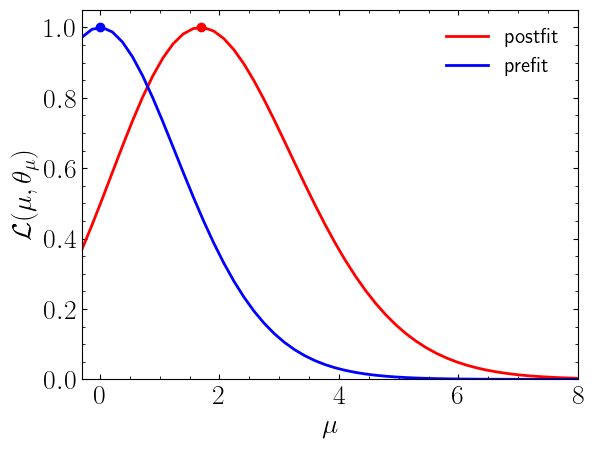

In [26]:
plt.plot(poi, llhd_postfit / max_llhd_postfit, color="r", label="postfit")
plt.scatter(muhat_postfit, 1, color="r")

plt.plot(poi, llhd_prefit / max_llhd_prefit, color="b", label="prefit")
plt.scatter(muhat_prefit, 1, color="b")

plt.legend()

plt.ylabel(r"$\mathcal{L}(\mu,\theta_\mu)$")
plt.xlabel(r"$\mu$")
plt.xlim([-0.3, 8])
plt.ylim([0, 1.05])
plt.show()

Now let us compute the expected and observed upper limits on signal strength ($\mu$) at 95% CL:

In [27]:
print(f"Observed upper limit on µ at 95% CL: {stat_model.poi_upper_limit():.5f}")

expected_pval = stat_model.poi_upper_limit(
    expected=spey.ExpectationType.aposteriori, expected_pvalue="1sigma"
)
muUL_apost = expected_pval[1]
print(
    "Expected upper limit on µ with ± 1σ at 95% CL: "
    + ",".join([f"{x:.3f}" for x in expected_pval])
)

Observed upper limit on µ at 95% CL: 4.66815
Expected upper limit on µ with ± 1σ at 95% CL: 2.834,3.764,5.183


We can use `confidence_level` flag to change the confidence level of our calculation

In [28]:
print(
    f"Observed upper limit on µ at 68% CL: {stat_model.poi_upper_limit(confidence_level=0.68):.5f}"
)

Observed upper limit on µ at 68% CL: 2.79069


Now let us compute the upper limit by hand:

In [29]:
poi = np.linspace(1, 7, 20)
poiUL = np.array(
    [
        stat_model.exclusion_confidence_level(
            poi_test=p, expected=spey.ExpectationType.aposteriori
        )
        for p in poi
    ]
)

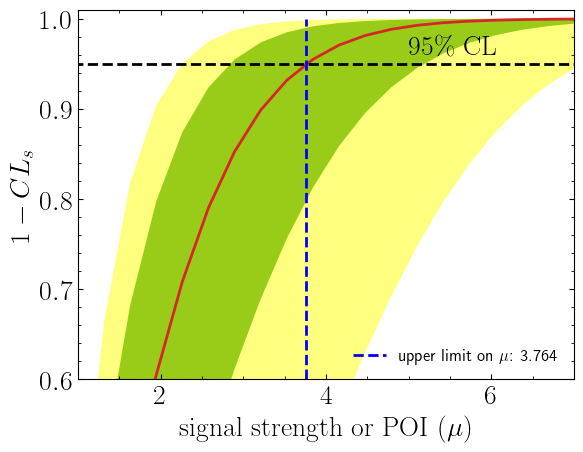

In [30]:
plt.plot(poi, poiUL[:, 2], color="tab:red")
plt.fill_between(poi, poiUL[:, 1], poiUL[:, 3], alpha=0.8, color="green", lw=0)
plt.fill_between(poi, poiUL[:, 0], poiUL[:, 4], alpha=0.5, color="yellow", lw=0)
plt.plot(
    [muUL_apost, muUL_apost],
    [0, 1],
    ls="dashed",
    color="b",
    label=f"upper limit on $\\mu$: {muUL_apost:.3f}",
)
plt.plot([0, 10], [0.95, 0.95], color="k", ls="dashed")
plt.xlabel(r"${\rm signal\ strength\ or\ POI }\ (\mu)$")
plt.ylabel("$1-CL_s$")
plt.xlim([1, 7])
plt.ylim([0.6, 1.01])
plt.text(5, 0.96, r"$95\%\ {\rm CL}$")
plt.legend(loc="lower right", fontsize=12)
plt.show()

Additionally we can compute the exclusion limit of our signal model to see if our model is excluded.

In [31]:
print(
    f"Observed exclusion confidence level, 1-CLs: {stat_model.exclusion_confidence_level()[0]:.5f}"
)

exp_cls = stat_model.exclusion_confidence_level(expected=spey.ExpectationType.aposteriori)
print(
    f"Expected exclusion confidence level, 1-CLs ± 1σ: {exp_cls[2]:.4f} - {exp_cls[2]-exp_cls[3]:.4f} + {exp_cls[1]-exp_cls[2]:.4f}"
)

Observed exclusion confidence level, 1-CLs: 0.13942
Expected exclusion confidence level, 1-CLs ± 1σ: 0.1620 - 0.0226 + 0.1182


Since our model is not excluded ($1-{\rm CL}_s < 0.95$), we may want to see the significance of our signal yields:

In [33]:
print(f"Z = {stat_model.significance()[1]:.3f}")

Z = 1.185
